# Pylops - Marchenko redatuming without fftshift

### Author: M.Ravasi

In this notebook I will show you how to use the **MDC** and **Marchenko** linear operators of *Pylops* to perform Marchenko redatuming by inversion

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

from scipy.sparse import csr_matrix, vstack
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import cg, lsqr
from scipy.signal import convolve, filtfilt

from pylops                            import LinearOperator
from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.utils.tapers               import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.waveeqprocessing.mdd       import *
from pylops.waveeqprocessing.marchenko import *
from pylops.optimization.leastsquares  import *

## Inputs

Input parameters 

In [2]:
inputfile = '../data/marchenko/input.npz'

vel = 2400.0        # velocity
toff = 0.045        # direct arrival time shift
nsmooth = 10        # time window smoothing 
nfmax = 500         # max frequency for MDC (#samples)
nstaper = 11        # source/receiver taper lenght
n_iter = 10         # iterations

jr = 1              # subsampling in r
js = 1              # subsampling in s

Load input

In [3]:
inputdata = np.load(inputfile)

Read and visualize geometry

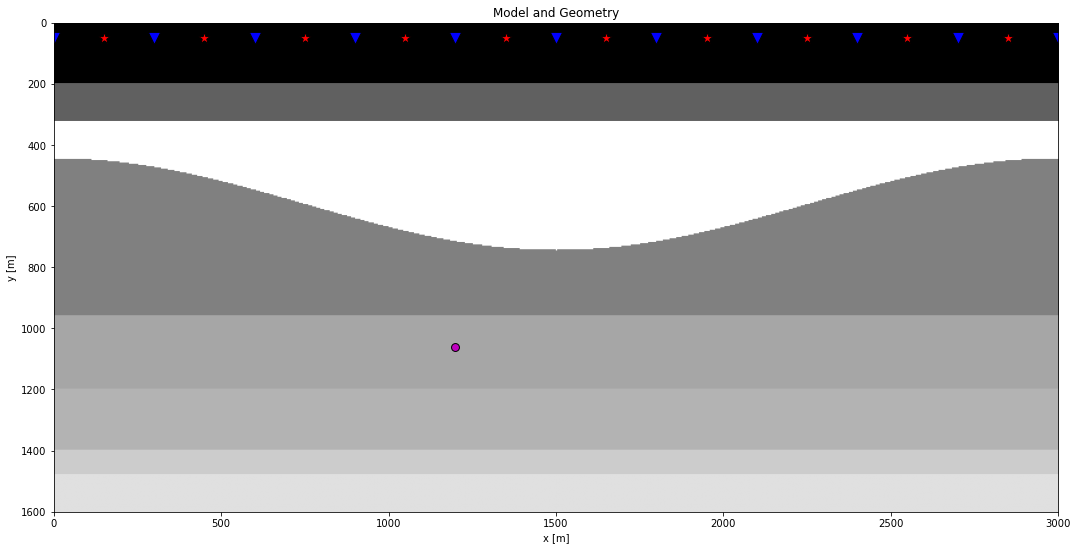

In [4]:
# Receivers
r = inputdata['r'][:,::jr]
nr = r.shape[1]
dr = r[0,1]-r[0,0]

# Sources
s = inputdata['s'][:,::js]
ns = s.shape[1]
ds = s[0,1]-s[0,0]

# Virtual points
vs = inputdata['vs']

# Density model
rho = inputdata['rho']
z, x = inputdata['z'], inputdata['x']

plt.figure(figsize=(18,9))
plt.imshow(rho, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(s[0, 5::10], s[1, 5::10], marker='*', s=150, c='r', edgecolors='k')
plt.scatter(r[0, ::10],  r[1, ::10], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(vs[0], vs[1], marker='.', s=250, c='m', edgecolors='k')
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]'),plt.title('Model and Geometry')
plt.xlim(x[0], x[-1]);

Read data

In [5]:
# time axis
t = inputdata['t']
ot, dt, nt = t[0], t[1]-t[0], len(t)

# data
R = inputdata['R'][::js, ::jr]
R = np.swapaxes(R, 0, 1) # R[r, s, f] (for data with dipole source, you need to integrate over sources)

# tapering
taper = taper3d(nt, [ns, nr], [nstaper, nstaper], tapertype='hanning')
R = R*taper

Read subsurface fields and wavelet to apply to subsurface fields

In [6]:
Gsub = inputdata['Gsub'][:, ::jr]
G0sub = inputdata['G0sub'][:, ::jr]
wav = inputdata['wav']
wav_c = np.argmax(wav)

# convolve with wavelet
Gsub = np.apply_along_axis(convolve, 0, Gsub, wav, mode='full')
Gsub = Gsub[wav_c:][:nt]
G0sub = np.apply_along_axis(convolve, 0, G0sub, wav, mode='full') 
G0sub = G0sub[wav_c:][:nt]

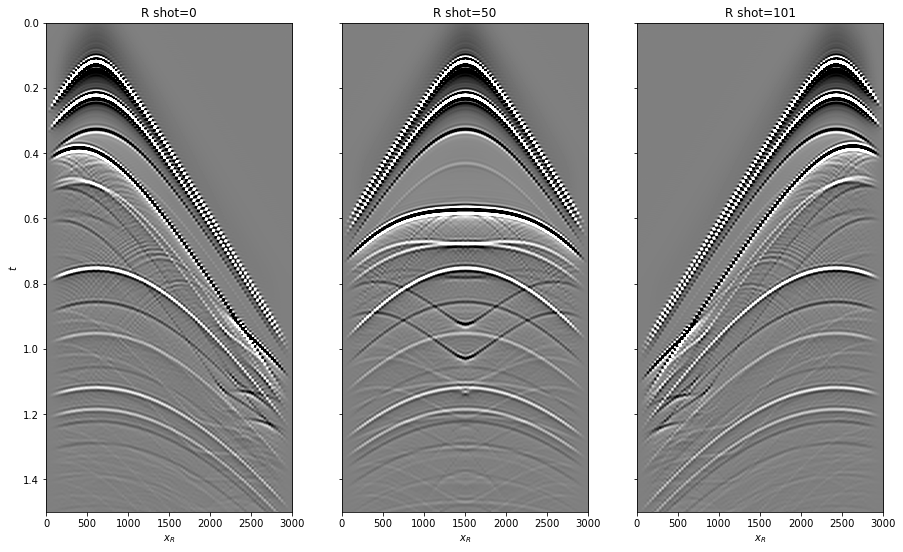

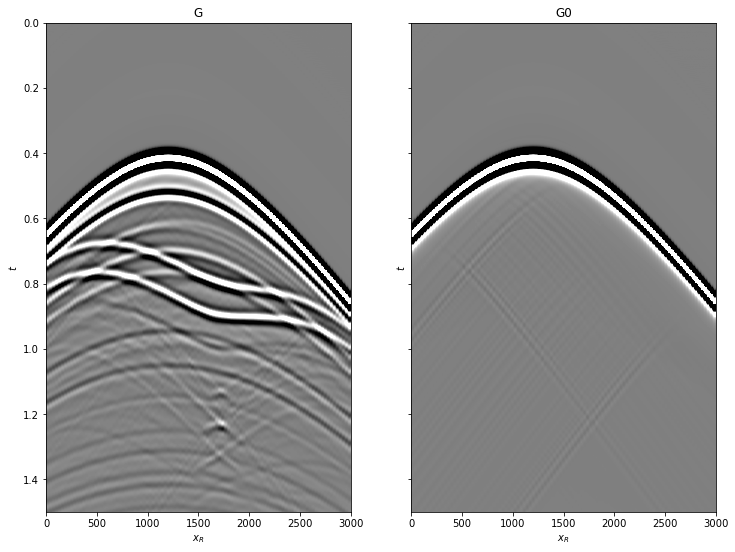

In [7]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(15, 9))
axs[0].imshow(R[20].T, cmap='gray', vmin=-1e-2, vmax=1e-2, extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[0].set_title('R shot=0'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(1.5, 0)
axs[1].imshow(R[ns//2].T, cmap='gray', vmin=-1e-2, vmax=1e-2, extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[1].set_title('R shot=%d' %(ns//2)), axs[1].set_xlabel(r'$x_R$')
axs[1].axis('tight')
axs[1].set_ylim(1.5, 0)
axs[2].imshow(R[-20].T, cmap='gray', vmin=-1e-2, vmax=1e-2, extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[2].set_title('R shot=%d' %ns), axs[2].set_xlabel(r'$x_R$')
axs[2].axis('tight');
axs[2].set_ylim(1.5, 0)

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(12, 9))
axs[0].imshow(Gsub, cmap='gray', vmin=-1e5, vmax=1e5, extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[0].set_title('G'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(1.5, 0)
axs[1].imshow(G0sub, cmap='gray', vmin=-1e5, vmax=1e5, extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[1].set_title('G0'), axs[1].set_xlabel(r'$x_R$'), axs[1].set_ylabel(r'$t$')
axs[1].axis('tight')
axs[1].set_ylim(1.5, 0);

## Marchenko preparation

Create window

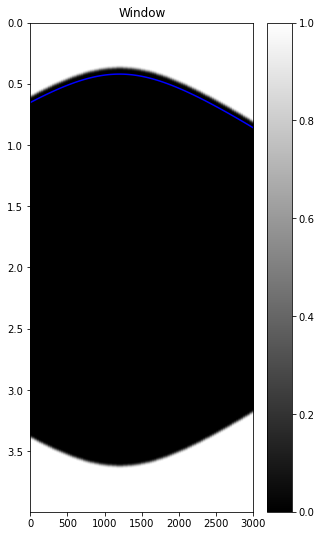

In [8]:
# direct arrival window - traveltime
directVS = np.sqrt((vs[0]-r[0])**2+(vs[1]-r[1])**2)/vel
directVS_off = directVS - toff

# window
idirectVS_off = np.round(directVS_off/dt).astype(np.int)
w = np.zeros((nr, nt))
for ir in range(nr):
    w[ir, :idirectVS_off[ir]]=1            
w = np.hstack((w[:, 1:], np.fliplr(w)))

if nsmooth>0:
    smooth=np.ones(nsmooth)/nsmooth
    w  = filtfilt(smooth, 1, w)    
    
fig, ax = plt.subplots(1, 1,  sharey=True, figsize=(5, 9))
im = ax.imshow(w.T, cmap='gray', extent=(r[0,0], r[0,-1], 2*t[-1], 0))
ax.plot(r[0], directVS,'b')
ax.set_title('Window'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
ax.axis('tight')
fig.colorbar(im, ax=ax);

Create analytical direct wave

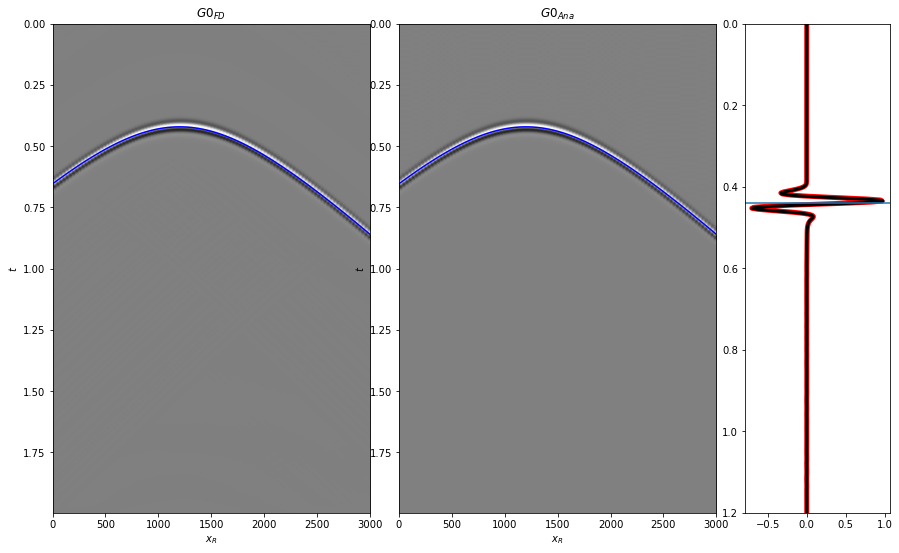

In [9]:
G0sub_ana = directwave(wav, directVS, nt, dt, nfft=2**11)

fig = plt.figure(figsize=(15,9))
ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 5), (0, 2), colspan=2)
ax3 = plt.subplot2grid((1, 5), (0, 4))

ax1.imshow(G0sub/G0sub.max(), cmap='gray', vmin=-1, vmax=1, 
           extent=(r[0,0], r[0,-1], t[-1], t[0]))
ax1.plot(r[0], directVS,'b')
ax1.set_title(r'$G0_{FD}$'), ax1.set_xlabel(r'$x_R$'), ax1.set_ylabel(r'$t$')
ax1.axis('tight')
ax2.imshow(G0sub_ana/G0sub_ana.max(), cmap='gray', vmin=-1, vmax=1, 
           extent=(r[0,0], r[0,-1], t[-1], t[0]))
ax2.plot(r[0], directVS,'b')
ax2.set_title(r'$G0_{Ana}$'), ax2.set_xlabel(r'$x_R$'), ax2.set_ylabel(r'$t$')
ax2.axis('tight')

ax3.plot(G0sub[:, nr//2]/G0sub.max(), t, 'r', lw=5)
ax3.plot(G0sub_ana[:, nr//2]/G0sub_ana.max(), t, 'k', lw=3)
ax3.axhline(directVS[nr//2])
ax3.set_ylim(1.2, 0);

For now we will use the direct wave obtained via finite-difference, but we will show later that Marchenko redatuming can converge to the correct solution also when using an analytical direct wave.

## Inversion

In [10]:
# Add negative time to operators
Rtwosided = np.concatenate((R, np.zeros((nr, ns, nt-1))), axis=-1)
Rtwosided_fft = np.fft.rfft(Rtwosided, 2*nt-1, axis=-1)/np.sqrt(2*nt-1)
Rtwosided_fft = Rtwosided_fft[...,:nfmax]
Rtwosided_fft = Rtwosided_fft.transpose(2, 0, 1) # R[f, r, s]

# Operators
Rop = MDC(Rtwosided_fft, nt=2*nt-1, nv=1, dt=dt, dr=ds, twosided=False)
R1op = MDC(Rtwosided_fft, nt=2*nt-1, nv=1, dt=dt, dr=ds, twosided=False, conj=True)

# Input focusing function
fd_plus =  np.concatenate((np.zeros((nt-1, nr)), np.fliplr(G0sub.T).T))
#fd_plus =  np.concatenate((np.zeros((nt, nr)), np.flipud(G0sub[1:])))

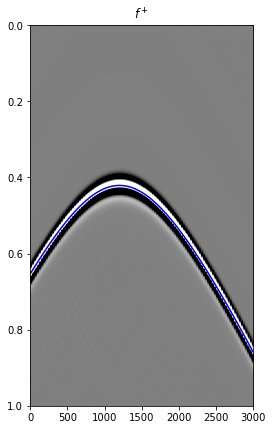

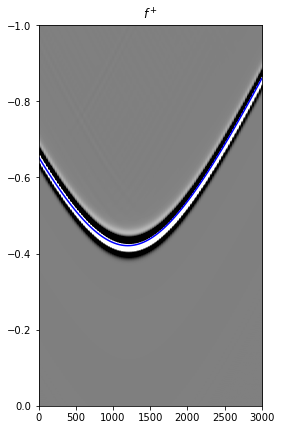

In [11]:
plt.figure(figsize=(4, 7))
plt.imshow(G0sub, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], r[0,-1], t[-1], 0))
plt.title(r'$f^+$'), axs[0].set_xlabel(r'$x_R$')
plt.plot(r[0], directVS,'b')
plt.axis('tight')
plt.ylim(1, 0);

plt.figure(figsize=(4, 7))
plt.imshow(np.fft.ifftshift(fd_plus.T, axes=1).T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
plt.title(r'$f^+$'), axs[0].set_xlabel(r'$x_R$')
plt.plot(r[0], -directVS,'b')
plt.axis('tight')
plt.ylim(0,-1);

Create Marchenko operator

In [12]:
Wop = Diagonal(w.T.flatten())
Iop = Identity(nr*(2*nt-1))

Mop = VStack([HStack([Iop, -1*Wop*Rop]),
              HStack([-1*Wop*R1op, Iop])])*BlockDiag([Wop, Wop])
Gop = VStack([HStack([Iop, -1*Rop]),
              HStack([-1*R1op, Iop])])

dottest(Gop, 2*nr*(2*nt-1), 2*nr*(2*nt-1), verb=True)
dottest(Mop, 2*nr*(2*nt-1), 2*nr*(2*nt-1), verb=True);

Dot test passed, v^H(Opu)=-38.44977064786957 - u^H(Op^Hv)=-38.449770647866444
Dot test passed, v^H(Opu)=235.74149157802105 - u^H(Op^Hv)=235.74149157802148


Run standard redatuming as benchmark

In [13]:
p0_minus = Rop * fd_plus.flatten()
p0_minus = p0_minus.reshape((2*nt-1), nr).T

Create data, adjoint and inverse focusing functions

In [14]:
d = Wop*Rop*fd_plus.flatten()
d = np.concatenate((d.reshape(2*nt-1, nr), np.zeros((2*nt-1, nr))))

f1_adj = Mop.H*d.flatten()
f1_inv = lsqr(Mop, d.flatten(), iter_lim=n_iter, show=True)[0]

f1_adj = f1_adj.reshape(2*(2*nt-1), nr)
f1_inv = f1_inv.reshape(2*(2*nt-1), nr)

 
LSQR            Least-squares solution of  Ax = b
The matrix A has 322998 rows and 322998 columns
damp = 0.00000000000000e+00   calc_var =        0
atol = 1.00e-06                 conlim = 1.00e+08
btol = 1.00e-06               iter_lim =       10
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   2.983e+07  2.983e+07    1.0e+00  3.5e-08
     1  0.00000e+00   1.311e+07  1.311e+07    4.4e-01  9.2e-01   1.1e+00  1.0e+00
     2  0.00000e+00   7.406e+06  7.406e+06    2.5e-01  3.9e-01   1.8e+00  2.2e+00
     3  0.00000e+00   5.479e+06  5.479e+06    1.8e-01  3.3e-01   2.1e+00  3.4e+00
     4  0.00000e+00   3.659e+06  3.659e+06    1.2e-01  3.3e-01   2.5e+00  5.2e+00
     5  0.00000e+00   2.780e+06  2.780e+06    9.3e-02  2.6e-01   2.9e+00  6.8e+00
     6  0.00000e+00   2.244e+06  2.244e+06    7.5e-02  2.3e-01   3.2e+00  8.5e+00
     7  0.00000e+00   1.498e+06  1.498e+06    5.0e-02  2.5e-01   3.6e+00  1.1e+01
     8  0.00000e+00   1.105e+0

Add initial guess to estimated focusing functions

In [15]:
f1_adj_tot = f1_adj + np.concatenate((np.zeros((2*nt-1, nr)),
                                      np.concatenate((np.zeros((nt-1, nr)),
                                                      np.fliplr(G0sub.T).T), axis=0)))

f1_inv_tot = f1_inv + np.concatenate((np.zeros((2*nt-1, nr)),
                                      fd_plus))

Estimate Green's functions

In [16]:
g_adj = Gop*f1_adj_tot.flatten()
g_inv = Gop*f1_inv_tot.flatten()

g_adj = g_adj.reshape(2*(2*nt-1), nr)
g_inv = g_inv.reshape(2*(2*nt-1), nr)

Extract up and down focusing and Green's functions from model vectors

In [17]:
f1_adj_minus, f1_adj_plus =  f1_adj_tot[:(2*nt-1)].T, f1_adj_tot[(2*nt-1):].T
f1_inv_minus, f1_inv_plus =  f1_inv_tot[:(2*nt-1)].T, f1_inv_tot[(2*nt-1):].T

g_adj_minus, g_adj_plus =  -g_adj[:(2*nt-1)].T, np.fliplr(g_adj[(2*nt-1):].T)
g_inv_minus, g_inv_plus =  -g_inv[:(2*nt-1)].T, np.fliplr(g_inv[(2*nt-1):].T)

g_inv_tot = g_inv_minus + g_inv_plus

Visualization

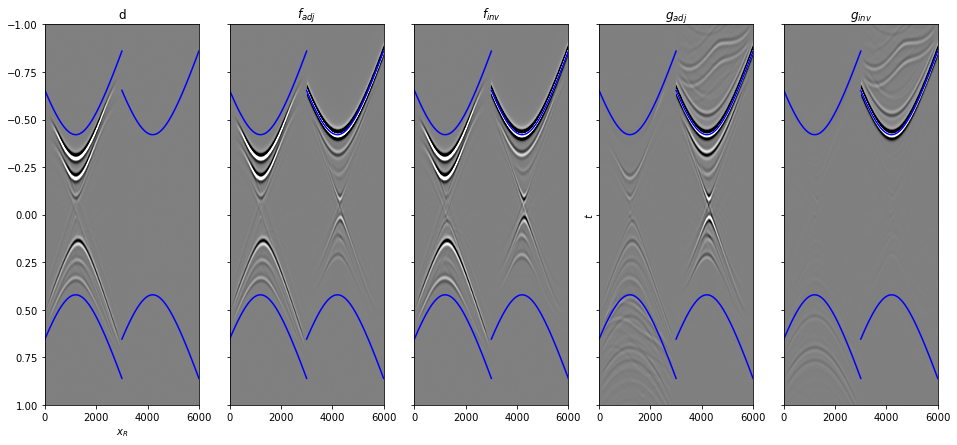

In [18]:
# Need to recreate combined data as new implementation stacks over time instead of space
d = np.concatenate((d[:(2*nt-1)], d[(2*nt-1):]), axis=1).T
f1_adj_tot = np.concatenate((f1_adj_tot[:(2*nt-1)], f1_adj_tot[(2*nt-1):]), axis=1).T
f1_inv_tot = np.concatenate((f1_inv_tot[:(2*nt-1)], f1_inv_tot[(2*nt-1):]), axis=1).T
g_adj = np.concatenate((g_adj[:(2*nt-1)], g_adj[(2*nt-1):]), axis=1).T
g_inv = np.concatenate((g_inv[:(2*nt-1)], g_inv[(2*nt-1):]), axis=1).T

fig, axs = plt.subplots(1, 5, sharey=True, figsize=(16, 7))
axs[0].imshow(np.fft.ifftshift(d, axes=1).T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], 2*r[0,-1], t[-1], -t[-1]))
axs[0].set_title('d'), axs[0].set_xlabel(r'$x_R$'), axs[3].set_ylabel(r'$t$')
axs[0].plot(r[0], directVS,'b'),axs[0].plot(r[0], -directVS,'b')
axs[0].plot(r[0]+r[0,-1], directVS,'b'),axs[0].plot(r[0]+r[0,-1], -directVS,'b')
axs[0].axis('tight')
axs[0].set_ylim(1, -1)
axs[1].imshow(np.fft.ifftshift(f1_adj_tot, axes=1).T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], 2*r[0,-1], t[-1], -t[-1]))
axs[1].set_title(r'$f_{adj}$'), axs[0].set_xlabel(r'$x_R$')
axs[1].plot(r[0], directVS,'b'),axs[1].plot(r[0], -directVS,'b')
axs[1].plot(r[0]+r[0,-1], directVS,'b'),axs[1].plot(r[0]+r[0,-1], -directVS,'b')
axs[1].axis('tight')
axs[1].set_ylim(1, -1);
axs[2].imshow(np.fft.ifftshift(f1_inv_tot, axes=1).T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], 2*r[0,-1], t[-1], -t[-1]))
axs[2].set_title(r'$f_{inv}$'), axs[0].set_xlabel(r'$x_R$')
axs[2].plot(r[0], directVS,'b'),axs[2].plot(r[0], -directVS,'b')
axs[2].plot(r[0]+r[0,-1], directVS,'b'),axs[2].plot(r[0]+r[0,-1], -directVS,'b')
axs[2].axis('tight')
axs[2].set_ylim(1, -1);
axs[3].imshow(np.fft.ifftshift(g_adj, axes=1).T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], 2*r[0,-1], t[-1], -t[-1]))
axs[3].set_title(r'$g_{adj}$'), axs[0].set_xlabel(r'$x_R$')
axs[3].plot(r[0], directVS,'b'),axs[3].plot(r[0], -directVS,'b')
axs[3].plot(r[0]+r[0,-1], directVS,'b'),axs[3].plot(r[0]+r[0,-1], -directVS,'b')
axs[3].axis('tight')
axs[3].set_ylim(1, -1);
axs[4].imshow(np.fft.ifftshift(g_inv, axes=1).T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], 2*r[0,-1], t[-1], -t[-1]))
axs[4].set_title(r'$g_{inv}$'), axs[0].set_xlabel(r'$x_R$')
axs[4].plot(r[0], directVS,'b'),axs[4].plot(r[0], -directVS,'b')
axs[4].plot(r[0]+r[0,-1], directVS,'b'),axs[4].plot(r[0]+r[0,-1], -directVS,'b')
axs[4].axis('tight')
axs[4].set_ylim(1, -1);

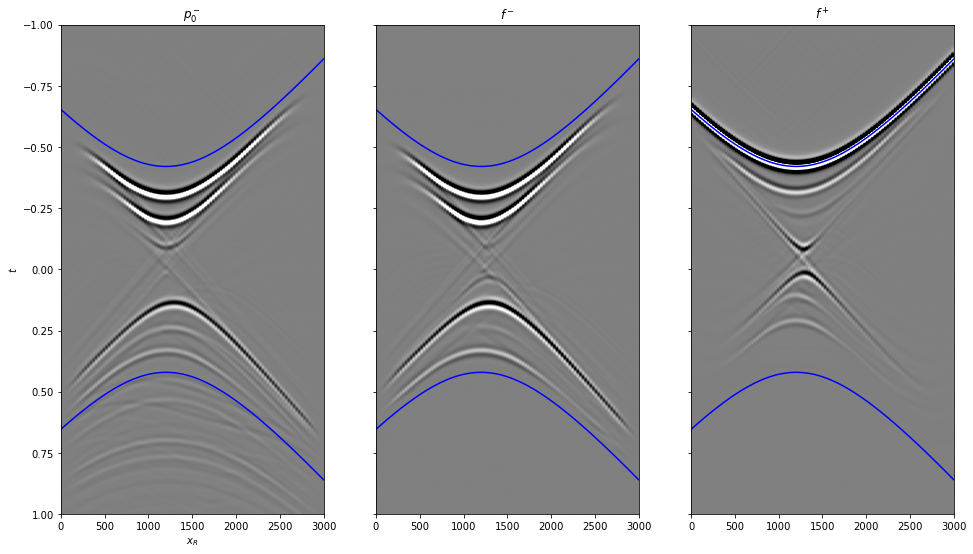

In [19]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16, 9))
axs[0].imshow(np.fft.ifftshift(p0_minus, axes=1).T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[0].set_title(r'$p_0^-$'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].plot(r[0], directVS,'b'),axs[0].plot(r[0], -directVS,'b')
axs[0].axis('tight')
axs[0].set_ylim(1, -1);
axs[1].imshow(np.fft.ifftshift(f1_inv_minus, axes=1).T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[1].set_title(r'$f^-$'), axs[0].set_xlabel(r'$x_R$')
axs[1].plot(r[0], directVS,'b'),axs[1].plot(r[0], -directVS,'b')
axs[1].axis('tight')
axs[1].set_ylim(1, -1);
axs[2].imshow(np.fft.ifftshift(f1_inv_plus, axes=1).T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[2].set_title(r'$f^+$'), axs[0].set_xlabel(r'$x_R$')
axs[2].plot(r[0], directVS,'b'),axs[2].plot(r[0], -directVS,'b')
axs[2].axis('tight')
axs[2].set_ylim(1, -1);

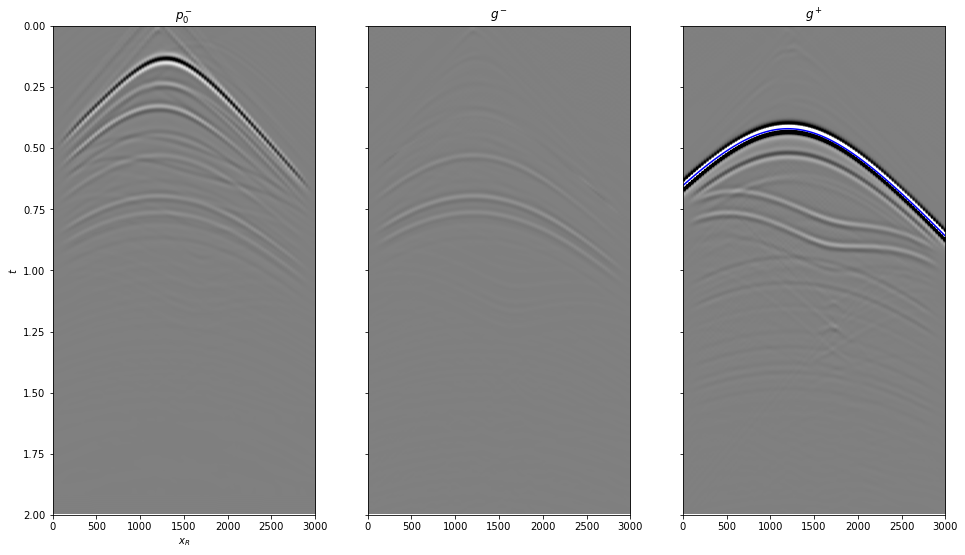

In [20]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16, 9))
axs[0].imshow(np.fft.ifftshift(p0_minus, axes=1).T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[0].set_title(r'$p_0^-$'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(2, 0);
axs[1].imshow(np.fft.ifftshift(g_inv_minus, axes=1).T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[1].set_title(r'$g^-$'), axs[0].set_xlabel(r'$x_R$')
axs[1].axis('tight')
axs[1].set_ylim(2, 0);
axs[2].imshow(np.fft.ifftshift(g_inv_plus, axes=1).T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[2].plot(r[0], directVS,'b')
axs[2].set_title(r'$g^+$'), axs[0].set_xlabel(r'$x_R$')
axs[2].axis('tight')
axs[2].set_ylim(2, 0);

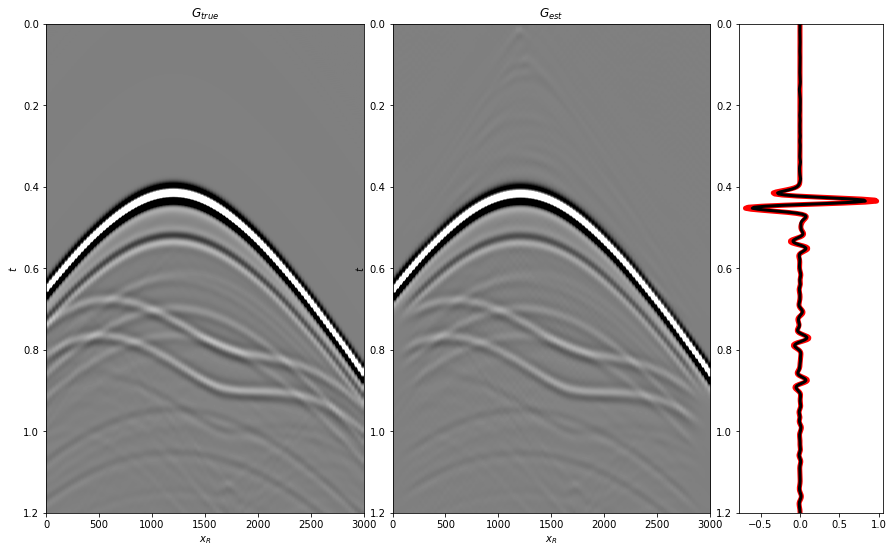

In [21]:
fig = plt.figure(figsize=(15,9))
ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 5), (0, 2), colspan=2)
ax3 = plt.subplot2grid((1, 5), (0, 4))

ax1.imshow(Gsub, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], r[0,-1], t[-1], t[0]))
ax1.set_title(r'$G_{true}$'), ax1.set_xlabel(r'$x_R$'), ax1.set_ylabel(r'$t$')
ax1.axis('tight')
ax1.set_ylim(1.2, 0)
ax2.imshow(np.fft.ifftshift(g_inv_tot, axes=1).T, cmap='gray', vmin=-5e5, vmax=5e5, 
              extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
ax2.set_title(r'$G_{est}$'), ax2.set_xlabel(r'$x_R$'), ax2.set_ylabel(r'$t$')
ax2.axis('tight')
ax2.set_ylim(1.2, 0)

ax3.plot(Gsub[:, nr//2]/Gsub.max(), t, 'r', lw=5)
ax3.plot(g_inv_tot[nr//2, :nt]/g_inv_tot.max(), t, 'k', lw=3)
ax3.set_ylim(1.2, 0);